
LATER Fitting Exercise (Python version)

Adapted from Joshua I. Gold (University of Pennsylvania)
by [Your Name]

This example demonstrates fitting the LATER model to RT data by
finding muR and deltaS that maximize the likelihood of observed RTs.

In [6]:
import numpy as np
from scipy.optimize import minimize, Bounds, differential_evolution
from scipy.stats import norm

# 1. Get the data

def later_getData(filename=None, condition=None, cutoff=0.2):
    np.random.seed(42)
    true_muR = 300     # arbitrary "rate" mean
    true_deltaS = 2.0  # arbitrary "signal" variability

    mu = true_muR / true_deltaS
    sigma = 1 / true_deltaS

    n_trials = 500
    invRT = np.random.normal(mu, sigma, n_trials)
    RTs = 1 / invRT
    RTs = RTs[RTs > cutoff]  # remove express saccades
    if RTs.size == 0:
        print("⚠️ No RTs survived the cutoff; lowering cutoff to 0.")
        RTs = later_getData([], [], 0.0)
    return RTs

RTs = later_getData()

⚠️ No RTs survived the cutoff; lowering cutoff to 0.


In [7]:
#2. Define the objective function (negative log-likelihood)
def later_negloglik(fits, RTs):
    muR, deltaS = fits
    if muR <= 0 or deltaS <= 0:
        return np.inf  # Penalize invalid (non-positive) parameters

    mu = muR / deltaS
    sigma = 1 / deltaS

    invRTs = 1 / RTs
    logpdf = norm.logpdf(invRTs, loc=mu, scale=sigma)
    negloglik = -np.sum(logpdf)
    return negloglik

# anonymous-function equivalent
laterErrFcn = lambda fits: later_negloglik(fits, RTs)

In [8]:
# 3. Define initial conditions and parameter bounds

lower_bounds = [0.001, 0.001]
upper_bounds = [1000, 1000]

# initial guess based on reciprocal RTs
invRT = 1 / RTs
initial_muR = np.mean(invRT) / np.std(invRT)
initial_deltaS = 1 / np.std(invRT)
initial_values = [initial_muR, initial_deltaS]

In [9]:
# 4. Run the fit (using global + local search)

# First, do a global search with differential evolution
bounds = Bounds(lower_bounds, upper_bounds)
result_global = differential_evolution(
    laterErrFcn, bounds=bounds, strategy='best1bin', maxiter=1000, tol=1e-6
)

# Refine with local optimizer (like fmincon in MATLAB)
result_local = minimize(
    laterErrFcn,
    result_global.x,
    method='trust-constr',
    bounds=bounds,
    options={'maxiter': 3000, 'disp': True}
)

fits = result_local.x
nllk = result_local.fun

print("Best-fitting parameters:")
print(f"  muR     = {fits[0]:.4f}")
print(f"  deltaS  = {fits[1]:.4f}")
print(f"  NegLogL = {nllk:.4f}")

`xtol` termination condition is satisfied.
Number of iterations: 115, function evaluations: 276, CG iterations: 105, optimality: 3.47e-02, constraint violation: 0.00e+00, execution time: 0.039 s.
Best-fitting parameters:
  muR     = 306.0708
  deltaS  = 2.0404
  NegLogL = 352.9328


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/optimize/_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)



Model fit summary:
  Mean(1/RT): data = 150.0034, model = 150.0034
  Std(1/RT):  data = 0.4901, model = 0.4901


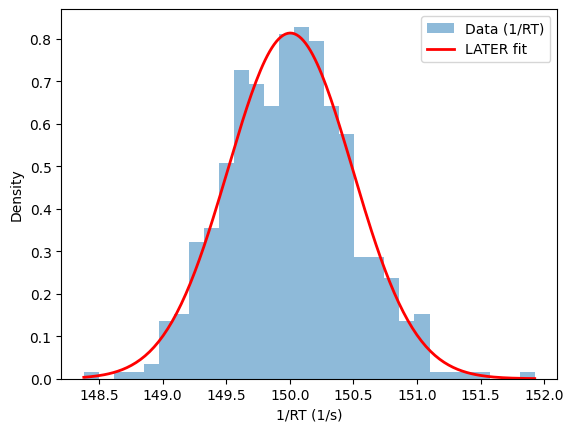

In [10]:
# 5. Evaluate the fits

# Check how well the fitted model predicts reciprocal RTs
mu_fit = fits[0] / fits[1]
sigma_fit = 1 / fits[1]

print("\nModel fit summary:")
print(f"  Mean(1/RT): data = {np.mean(invRT):.4f}, model = {mu_fit:.4f}")
print(f"  Std(1/RT):  data = {np.std(invRT):.4f}, model = {sigma_fit:.4f}")

# Optional: visualize the fit
import matplotlib.pyplot as plt

plt.hist(invRT, bins=30, density=True, alpha=0.5, label="Data (1/RT)")
x = np.linspace(min(invRT), max(invRT), 200)
plt.plot(x, norm.pdf(x, mu_fit, sigma_fit), 'r-', lw=2, label="LATER fit")
plt.xlabel("1/RT (1/s)")
plt.ylabel("Density")
plt.legend()
plt.show()